In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimage

from tensorflow.keras import applications, models

from utils import (create_model, train_gen_overlay_box, load_images, load_backgrounds, show_batch, tune_contrast_light,
                  transform_image_mask_box, lay_over_background, load_df)

In [5]:
def show_batch_box(batch, label, bs1=16):
    coords = label["box_coords"]
    classes = df["name"].values[label["class_probs"].argmax(axis=1)]
    fig, axs = plt.subplots(bs1 // 4, 4, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)
    for i in range(min(bs1, batch.shape[0])):
        #print(coords[i])
        x0, y0, x1, y1, x2, y2, x3, y3 = list(coords[i])
        x0 *= batch.shape[1]
        x1 *= batch.shape[1]
        x2 *= batch.shape[1]
        x3 *= batch.shape[1]
        
        y0 *= batch.shape[2]
        y1 *= batch.shape[2]
        y2 *= batch.shape[2]
        y3 *= batch.shape[2]
        
        axs[i // 4, i % 4].set_title(classes[i])
        axs[i // 4, i % 4].plot([y0, y1, y2, y3, y0], [x0, x1, x2, x3, x0])
        axs[i // 4, i % 4].scatter([y0], [x0], c="r")
        axs[i // 4, i % 4].scatter([y1], [x1], c="g")
        axs[i // 4, i % 4].scatter([y2], [x2], c="b")
        axs[i // 4, i % 4].set_xlim(0, batch.shape[1])
        axs[i // 4, i % 4].set_ylim(0, batch.shape[2])
        axs[i // 4, i % 4].imshow((batch[i] + 1) * 0.5)
        #print(x0, y0, x1, y1)
        
def eval_on_batch(batch, y_batch):
    
    preds_one, _ = seq2(batch, training=False)
    preds_one = preds_one.numpy()
    pred_one = preds_one.argmax(axis=1)
    y_one = y_batch.argmax(axis=1)
    res_batch = pd.DataFrame({"pred": pred_one, "y": y_one})
    return res_batch, pd.DataFrame(preds_one)

def eval_on_batches(train_gen, n_batches):
    probs = []
    res = []
    #images_test = []

    for j in range(n_batches):
        print(j)
        batch, label = next(train_gen)
        res_batch, preds_one = eval_on_batch(batch, label["class_probs"])
        res.append(res_batch)
        probs.append(preds_one)
        #images_test.append(batch)

    res = pd.concat(res, ignore_index=True)
    probs = pd.concat(probs, ignore_index=True)

    res["wrong"] = res["pred"] != res["y"]
    res["correct"] = res["pred"] == res["y"]
    loss = - np.log(probs).values[np.arange(probs.shape[0]), res["y"].values]
    res["loss"] = loss
    return res#, images_test


def eval_on_example(batch, y_batch):
    
    preds_one = seq2(batch, training=False).numpy()
    pred_one = preds_one.argmax(axis=1)
    y_one = y_batch.argmax(axis=1)
    res_batch = pd.DataFrame({"pred": pred_one, "y": y_one})
    return res_batch, pd.DataFrame(preds_one)



from sklearn.cluster import KMeans

def get_colors(example_br, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(example_br.reshape(-1, 3))
    return np.expand_dims(kmeans.cluster_centers_, axis=0)

def cluster(example_br, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    transformed = kmeans.fit_transform(example_br.reshape(-1, 3))
    new_image = kmeans.cluster_centers_[transformed.argmin(axis=1), :].reshape(example_br.shape) 
    return new_image

def pred_resize_one_image(example, scale=1, shift=0):
    ex_w, ex_h = example.shape[:2]
    min_factor = min(width / ex_w , height / ex_h) * scale
    resized_example1 = cv2.resize(example, (int(ex_h * min_factor), int(ex_w * min_factor)))
    blank = backgrounds[0][:width, :height].copy() #np.random.rand(width, height, 3)  #np.zeros((width, height, 3))
    x0, y0 = int(width * shift), int(height * shift)
    x_min = min(resized_example1.shape[0] + x0, blank.shape[0])
    y_min = min(resized_example1.shape[1] + y0, blank.shape[1])
    blank[x0: x_min, y0: y_min, :] = resized_example1[: x_min - x0, : y_min - y0, :]
    preds, coords = pred_one_image(blank)
    return preds, coords, blank


def pred_one_image(blank):
    resized_example = np.expand_dims(blank, axis=0) 
    
    preds, coords = seq2(resized_example, training=False)
    preds = preds[0]
    preds = pd.Series(preds, index=df["name"][:n_classes]).sort_values(ascending=False)
    return preds, coords


def show(example_tuned):
    plt.imshow(((example_tuned + 1) * 0.5 * 255).astype(int))
    
    
def cluster_spatial(example, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)

    w, h = example.shape[:2]

    x_coord = np.array(list(range(w)) * h)
    y_coord = np.array(list(range(h)) * w)

    conc = np.concatenate([example.reshape(-1, 3), x_coord.reshape(-1, 1), y_coord.reshape(-1, 1)], axis=1)

    mn = conc.mean(axis=0)
    sd = conc.std(axis=0)
    conc_norm = (conc - mn) / sd
    preds = kmeans.fit_predict(conc_norm)
    transformed = kmeans.cluster_centers_[preds]

    img_trans = (transformed * sd + mn)[:, :-2].reshape(example.shape)
    return img_trans

In [6]:
df = load_df("sqlite:///countries/data/sqlite/countries.db")

In [7]:
df

id  enabled code3l code2l                          name  \
0      1     True    AFG     AF                   Afghanistan   
1      2     True    ALB     AL                       Albania   
2      3     True    DZA     DZ                       Algeria   
3      4     True    AND     AD                       Andorra   
4      5     True    AGO     AO                        Angola   
..   ...      ...    ...    ...                           ...   
243  244     True    USA     US                 United States   
244  245     True    VAT     VA            Vatican City State   
245  246     True    VGB     VG                Virgin Islands   
246  247     True    VIR     VI  United States Virgin Islands   
249  250     True    SSD     SS                   South Sudan   

                               name_official    flag_32    flag_128  \
0            Islamic Republic of Afghanistan  AF-32.png  AF-128.png   
1                        Republic of Albania  AL-32.png  AL-128.png   
2    People’s Democratic Republic of Algeria  DZ-32.png  DZ-128.png   
3                    Principality of Andorra  AD-32.png  AD-128.png   
4                         Republic of Angola  AO-32.png  AO-128.png   
..                                       ...        ...         ...   
243                 United States of America  US-32.png  US-128.png   
244                State of the Vatican City  VA-32.png  VA-128.png   
245                   British Virgin Islands  VG-32.png  VG-128.png   
246      Virgin Islands of the United States  VI-32.png  VI-128.png   
249                  Republic of South Sudan  SS-32.png  SS-128.png   

         latitude      longitude  zoom  
0     33.98299275    66.39159363     6  
1     41.00017358    19.87170014     7  
2     27.89861690     3.19771194     5  
3     42.54057088     1.55201340    11  
4    -12.16469683    16.70933622     6  
..            ...            ...   ...  
243   37.66895362  -102.39256450     4  
244   41.90377810    12.45340142    16  
245   17.67004187   -64.77411010    10  
246   18.01000938   -64.77411410     9  
249    7.91320803    30.15342434     6  

[233 rows x 11 columns]

In [3]:
images_path = "countries/data/flags/PNG-128/"

trained_model = applications.InceptionV3(weights="imagenet")
module = applications.inception_v3
width, height = 299, 299

load_df("sqlite:///countries/data/sqlite/countries.db")

images, masks = load_images(df, images_path,  module)

n_classes = images.shape[0]
y = np.identity(n_classes)

assert df.notnull().all().all()

for col in ['code3l', 'code2l', 'name', 'name_official', 'flag_32',
       'flag_128']:
    assert (df[col].value_counts() == 1).all()
    
    
backgrounds = load_backgrounds("val2017/*.jpg", module, width, height, lim=1000)

In [4]:
from tensorflow.keras.layers import Dense, LeakyReLU

In [5]:
seq2 = models.load_model("run_[]_cls_233_lr_0.001_bs_256_ts_8_tp_15288561_8620_model.hdf5",
                        custom_objects={'LeakyReLU': LeakyReLU})
#seq2 = create_model(n_classes, train_batch_norm=False)

In [6]:
batch_size = 256
train_gen = train_gen_overlay_box(batch_size, backgrounds, images, masks, y)
#test_gen = train_gen_overlay2(batch_size, test_backgrounds, images, masks)

#seq2.load_weights("inception3_run_[]_cls_250_lr_0.001_bs_128_ts_8_tp_11047162_950.hdf5")


In [7]:
batch, label = next(train_gen)

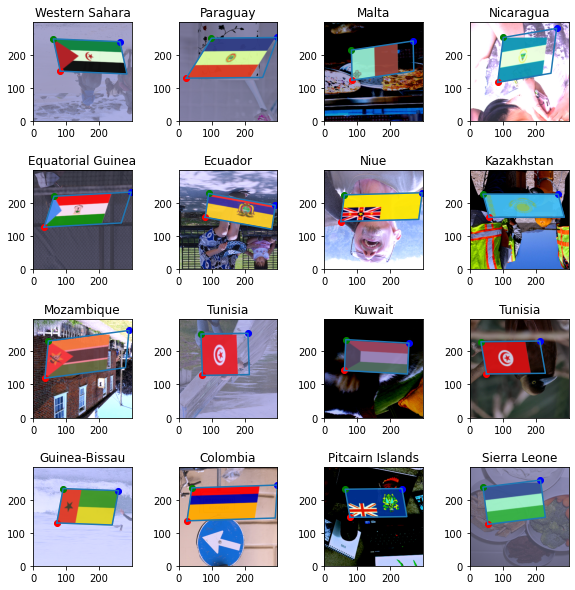

In [8]:
show_batch_box(batch, label)

In [9]:
preds, coords = seq2(batch, training=False)

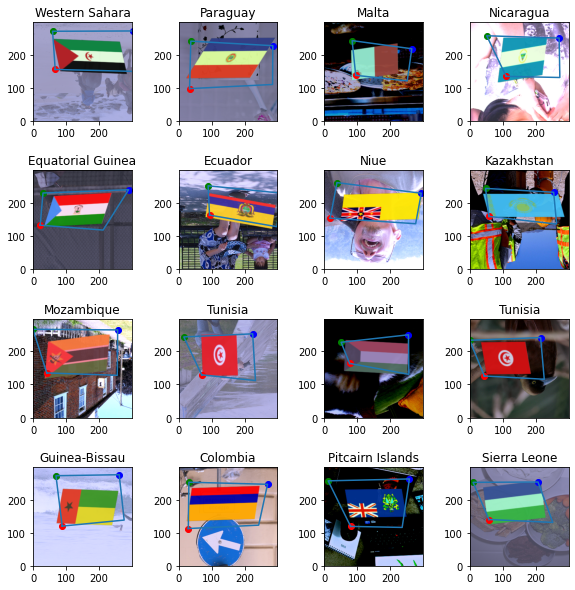

In [10]:
show_batch_box(batch, {"box_coords": coords.numpy(), "class_probs": preds.numpy()})

In [11]:
res_batch, pred_one = eval_on_batch(batch, label["class_probs"])
(res_batch["pred"] == res_batch["y"]).mean()

0.98828125

In [18]:
res = eval_on_batches(train_gen, 30)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/Users/grisha.oryol/Documents/projects/opencv/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


In [19]:
res["correct"].mean()

0.931640625

In [20]:
crosstab_abs = pd.crosstab(res["pred"], res["y"])
crosstab = crosstab_abs.div(crosstab_abs.sum())

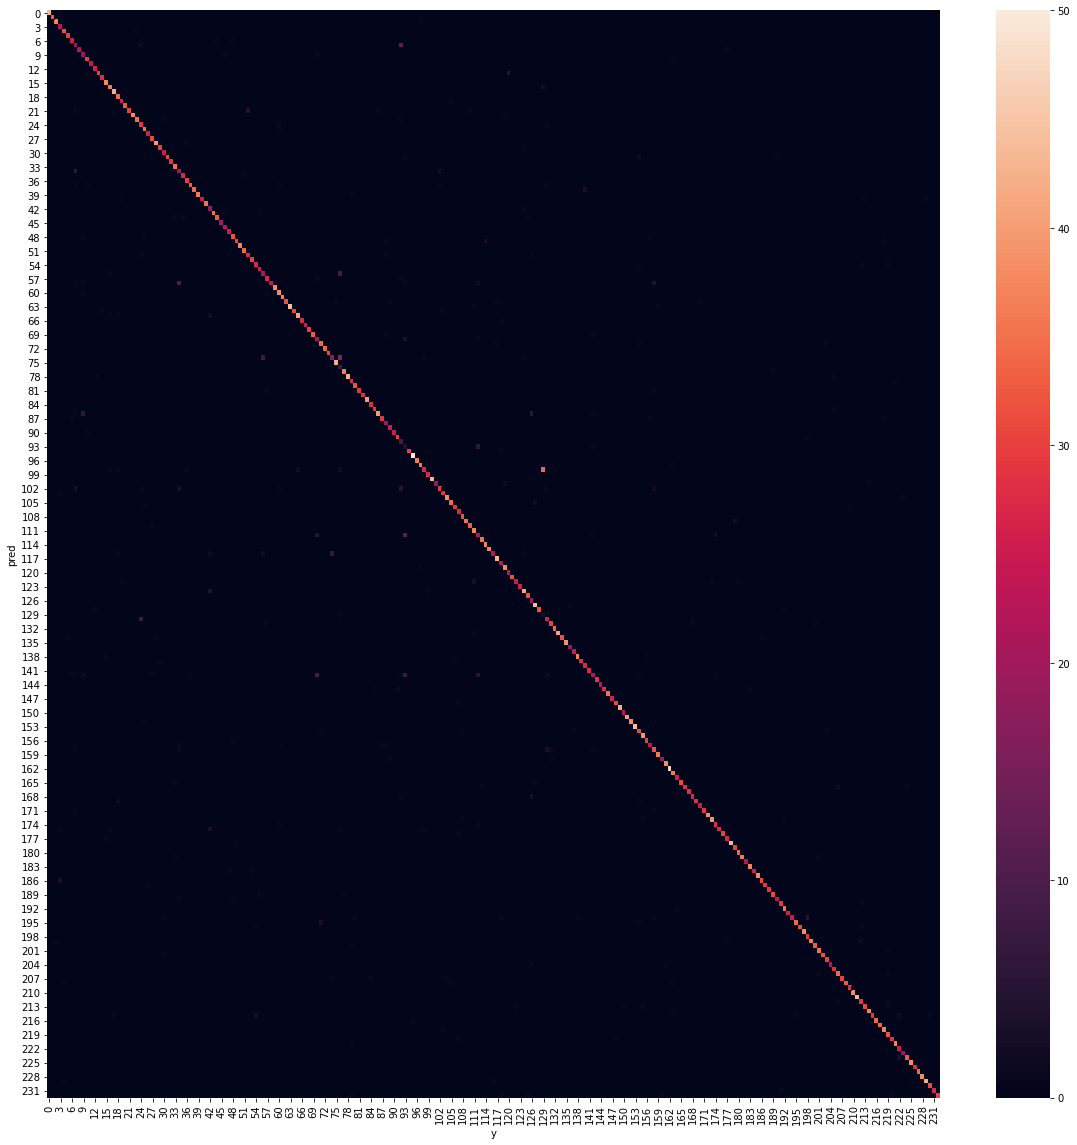

In [42]:
plt.figure(figsize=(20, 20))
sns.heatmap(crosstab_abs)

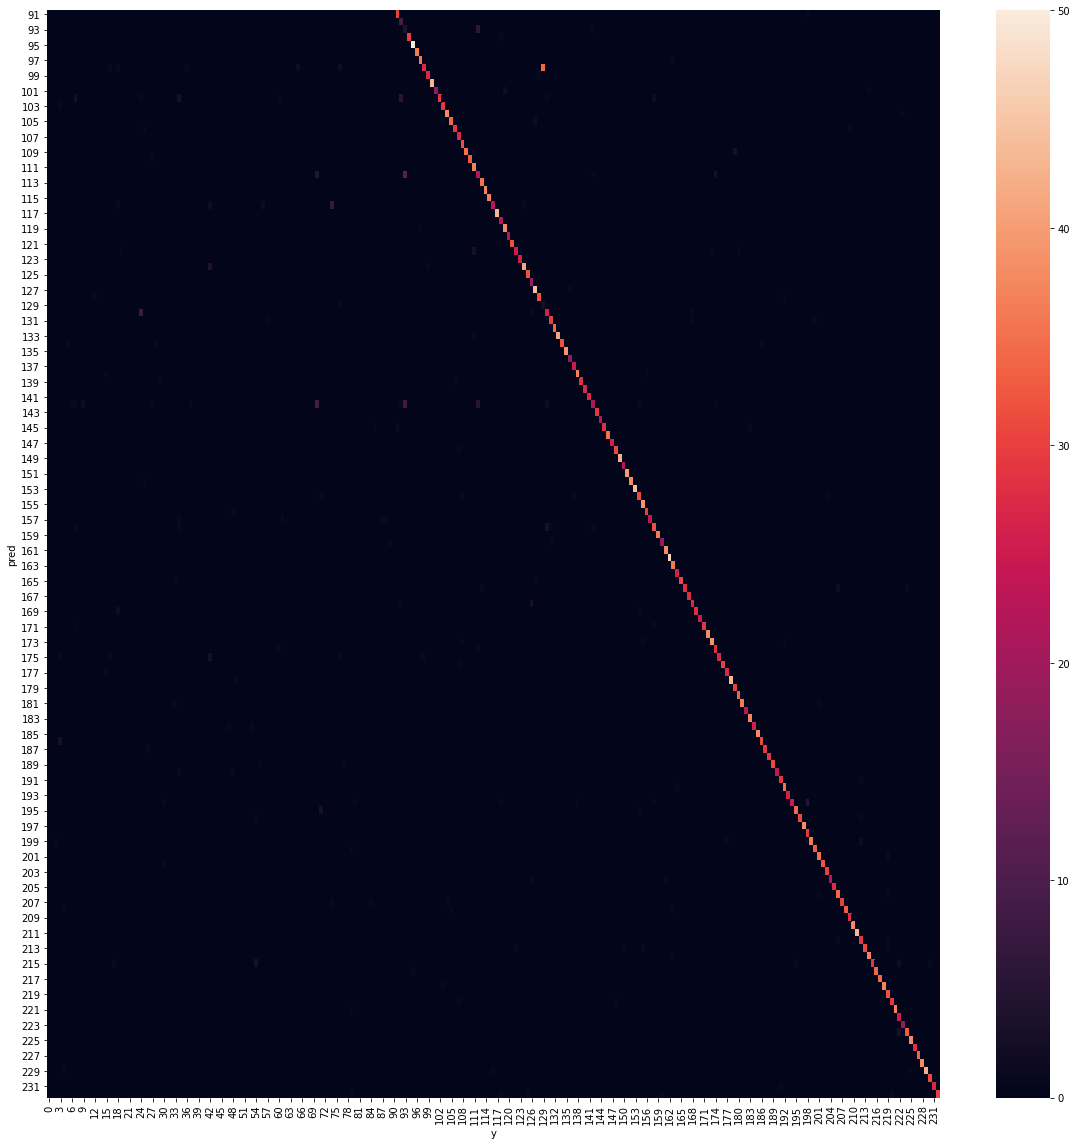

In [46]:
plt.figure(figsize=(20, 20))
sns.heatmap(crosstab_abs[91:])

In [24]:
res[res["wrong"]].groupby(["pred", "y"]).count()["wrong"].sort_values(ascending=False)[:5] / res.shape[0]

pred  y  
98    129    0.004427
74    76     0.002214
112   93     0.001563
7     92     0.001563
58    34     0.001302
Name: wrong, dtype: float64

In [49]:
from tensorflow.keras.models import Model

In [58]:
len(seq2.layers)

313

In [60]:
layer_model = Model(seq2.input, [seq2.layers[312].output])

In [93]:
blue_img = np.array([[[0, 0, 1]] * 299] * 299)
green_img = np.array([[[0, 1, 0]] * 299] * 299)

In [94]:
images.shape

(233, 64, 128, 3)

In [95]:
example = blue_img
ex_w, ex_h = example.shape[:2]
min_factor = min(width / ex_w , height / ex_h)
resized_example1 = cv2.resize(example, (int(ex_h * min_factor), int(ex_w * min_factor)))
blank = np.zeros((width, height, 3))
blank[:resized_example1.shape[0], :resized_example1.shape[1], :] = resized_example1
activations1 = layer_model(np.expand_dims(blank, axis=0)).numpy()

In [96]:
example = green_img
ex_w, ex_h = example.shape[:2]
min_factor = min(width / ex_w , height / ex_h)
resized_example1 = cv2.resize(example, (int(ex_h * min_factor), int(ex_w * min_factor)))
blank = np.zeros((width, height, 3))
blank[:resized_example1.shape[0], :resized_example1.shape[1], :] = resized_example1
activations2 = layer_model(np.expand_dims(blank, axis=0)).numpy()

In [97]:
activations1.argmax()

126

In [98]:
activations2.argmax()

165

In [45]:
res[res["y"] == 124]

pred    y  wrong  correct      loss
29      42  124   True    False  2.459301
638     76  124   True    False  2.502213
928     42  124   True    False  2.646413
966     42  124   True    False  3.204854
2151    76  124   True    False  3.964858
2165    74  124   True    False  2.025883

In [71]:
res[res["y"] == 42]

pred   y  wrong  correct      loss
72      42  42  False     True  0.028861
304     65  42   True    False  1.051260
387     42  42  False     True  0.069686
646     42  42  False     True  0.441112
1051    42  42  False     True  0.536740
1217    42  42  False     True  0.251600
1456    65  42   True    False  1.381871
1571    42  42  False     True  0.111280
1652    42  42  False     True  0.042672
1889    42  42  False     True  0.098761
2174    74  42   True    False  1.306127
2292    42  42  False     True  0.667063
2420    42  42  False     True  0.674664
2478    42  42  False     True  0.862997

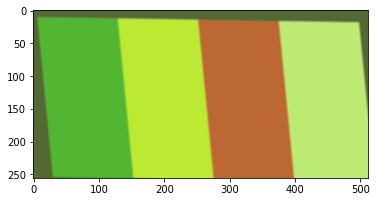

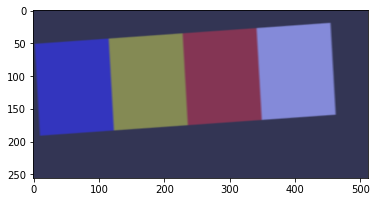

In [89]:
img = images[98]
im1, mask1, dst = transform_image_mask_box(img, masks[98])
# show(img)
# plt.show()
show(im1)

img = images[129]
im1, mask1, dst = transform_image_mask_box(img, masks[98])
#show(img)
plt.show()
show(im1)

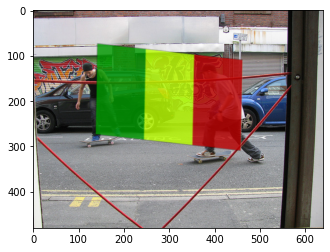

In [129]:
import random

img = images[98
            ]
im1, mask1, dst = transform_image_mask_box(img, masks[98])

imgs_trans = np.array([im1])
masks_trans = np.array([mask1])
backgrounds_sample = np.array([backgrounds[2]])
alpha_min=0.7

imgs_width, imgs_height = masks_trans.shape[1:-1]
        # select a random position in the background window
x_img, y_img = (random.randint(0, backgrounds_sample.shape[1] - imgs_width),
                random.randint(0, backgrounds_sample.shape[2] - imgs_height))

alpha = np.random.rand() * (1 - alpha_min) + alpha_min
overlayed = lay_over_background(backgrounds_sample, imgs_trans, masks_trans,
                                x_img, y_img, alpha)

show(overlayed[0])

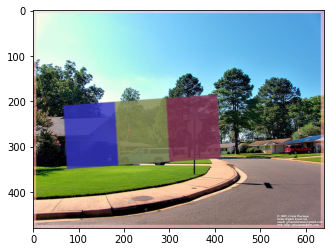

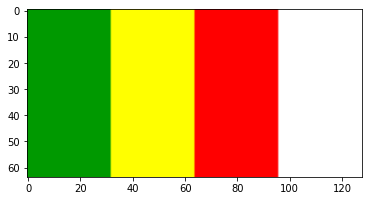

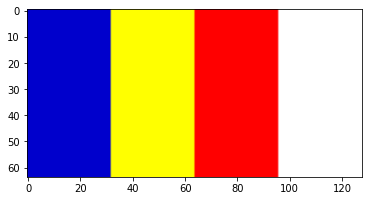

In [87]:
plt.imshow(((images[98] + 1) * 0.5 * 255).astype(int))
plt.show()
plt.imshow(((images[129] + 1) * 0.5 * 255).astype(int))
plt.show()

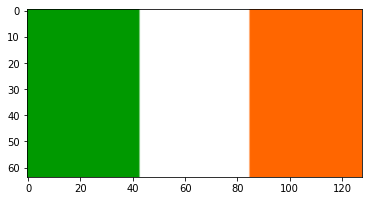

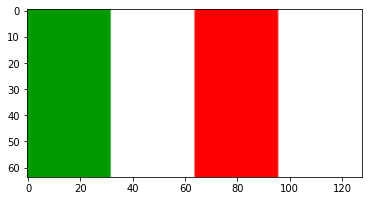

In [25]:
plt.imshow(((images[74] + 1) * 0.5 * 255).astype(int))
plt.show()
plt.imshow(((images[76] + 1) * 0.5 * 255).astype(int))
plt.show()

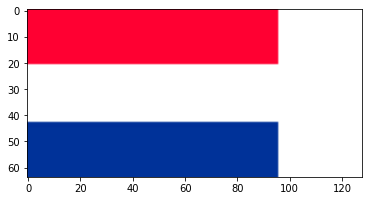

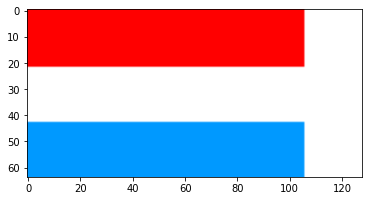

In [26]:
plt.imshow(((images[112] + 1) * 0.5 * 255).astype(int))
plt.show()
plt.imshow(((images[93] + 1) * 0.5 * 255).astype(int))
plt.show()

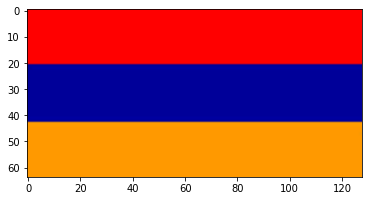

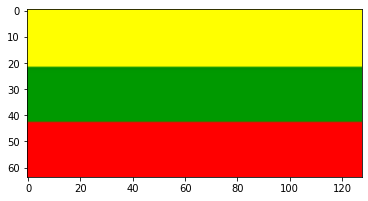

In [27]:
plt.imshow(((images[7] + 1) * 0.5 * 255).astype(int))
plt.show()
plt.imshow(((images[92] + 1) * 0.5 * 255).astype(int))
plt.show()

In [44]:
pd.DataFrame({"correct": res.groupby("y")["correct"].mean(), 
 "count": res.groupby("y")["correct"].count()}).sort_values("correct")

correct  count
y                   
124  0.000000      6
76   0.153846     13
34   0.333333      9
230  0.363636     11
92   0.384615     13
..        ...    ...
51   1.000000     16
48   1.000000     10
47   1.000000      8
136  1.000000     15
0    1.000000     12

[233 rows x 2 columns]

In [33]:
pred_resize_one_image(images[13][:, :, [0, 2, 1]])

name
Bangladesh                     0.214969
Palau                          0.149946
Japan                          0.079352
Laos                           0.025506
Algeria                        0.024510
                                 ...   
Iraq                           0.000041
Greece                         0.000041
United States                  0.000038
United Kingdom                 0.000026
Falkland Islands (Malvinas)    0.000025
Length: 233, dtype: float32

In [106]:
pred_resize_one_image(images[13])

name
Bangladesh                     0.359569
Palau                          0.082657
Japan                          0.078656
Jordan                         0.020014
Algeria                        0.016946
                                 ...   
Uruguay                        0.000039
Greece                         0.000034
Falkland Islands (Malvinas)    0.000030
Georgia                        0.000030
United Kingdom                 0.000028
Length: 233, dtype: float32

In [105]:
pred_resize_one_image(images[120])

name
Bangladesh                        0.036277
Palau                             0.033410
Japan                             0.031628
Belarus                           0.022711
Ukraine                           0.018443
                                    ...   
Åland Islands                     0.000584
Fiji                              0.000582
British Indian Ocean Territory    0.000563
United States                     0.000491
United Kingdom                    0.000403
Length: 233, dtype: float32

In [104]:
df.iloc[13]

id                                            14
enabled                                     True
code3l                                       BGD
code2l                                        BD
name                                  Bangladesh
name_official    People’s Republic of Bangladesh
flag_32                                BD-32.png
flag_128                              BD-128.png
latitude                             24.08273251
longitude                            90.49915527
zoom                                           7
Name: 13, dtype: object

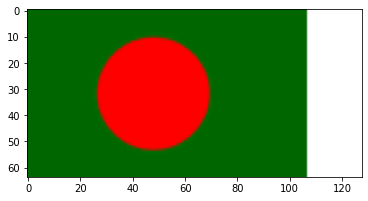

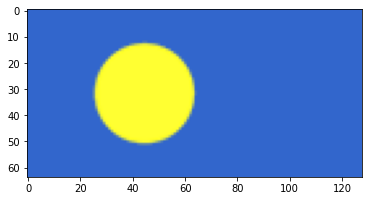

In [103]:
plt.imshow(((images[13] + 1) * 0.5 * 255).astype(int))
plt.show()
plt.imshow(((images[120] + 1) * 0.5 * 255).astype(int))
plt.show()

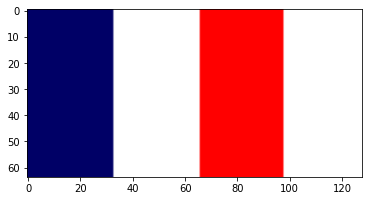

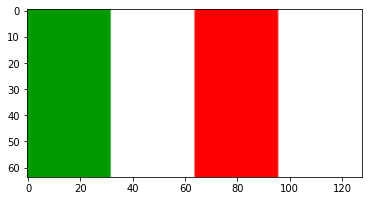

In [17]:
plt.imshow(((images[56] + 1) * 0.5 * 255).astype(int))
plt.show()
plt.imshow(((images[76] + 1) * 0.5 * 255).astype(int))
plt.show()

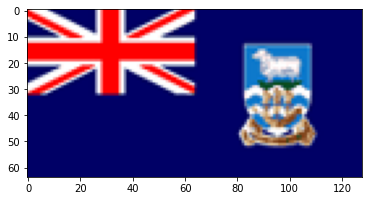

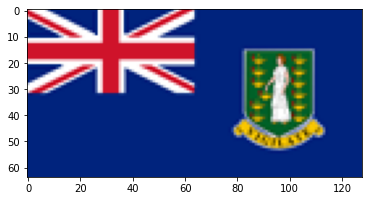

In [20]:
plt.imshow(((images[201] + 1) * 0.5 * 255).astype(int))
plt.show()
plt.imshow(((images[230] + 1) * 0.5 * 255).astype(int))
plt.show()

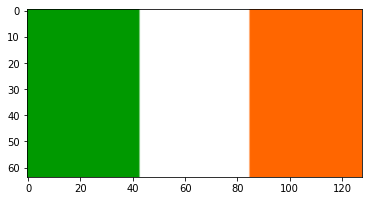

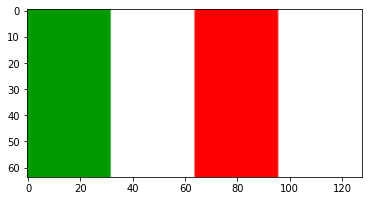

In [36]:
plt.imshow(((images[74] + 1) * 0.5 * 255).astype(int))
plt.show()
plt.imshow(((images[76] + 1) * 0.5 * 255).astype(int))
plt.show()

In [13]:
import matplotlib.image as mpimage
import cv2
import glob

In [14]:
examples = glob.glob("examples/*.jpeg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


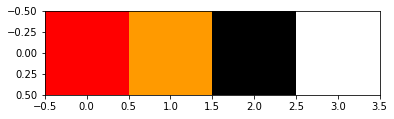

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


     0         1    2
2 -1.0 -0.999997 -1.0
0  1.0 -0.999998 -1.0
1  1.0  0.604069 -1.0
3  1.0  1.000000  1.0


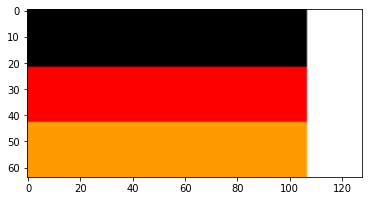

In [136]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit_transform(images[61].reshape(-1, 3))
plt.imshow(np.expand_dims(kmeans.cluster_centers_, axis=0))
plt.show()
plt.imshow(images[61])
centers = pd.DataFrame(kmeans.cluster_centers_)
print(centers.sort_values(list(centers.columns)))

In [25]:
n_clusters = 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


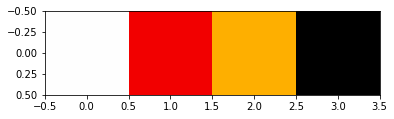

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


          0         1         2
3 -0.957106 -0.988599 -0.985680
1  0.950891 -0.928723 -0.987710
2  0.997189  0.689161 -0.994329
0  0.998447  0.998838  0.998485


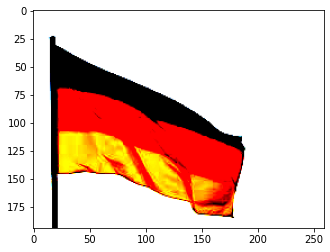

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


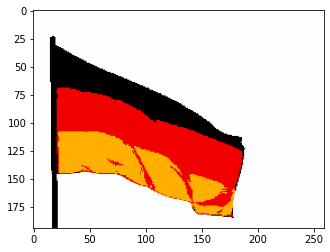

In [150]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)

d_light = 0.0
d_contr = 3
example_br = tune_contrast_light(example, d_light, d_contr)

transformed = kmeans.fit_transform(example_br.reshape(-1, 3))
plt.imshow(np.expand_dims(kmeans.cluster_centers_, axis=0))
plt.show()
plt.imshow(example_br)
centers = pd.DataFrame(kmeans.cluster_centers_)
print(centers.sort_values(list(centers.columns)))

plt.show()
new_image = kmeans.cluster_centers_[transformed.argmin(axis=1), :].reshape(example_br.shape) 
plt.imshow(new_image)

In [12]:
import glob
import cv2

name
Saudi Arabia    0.266236
Micronesia      0.082224
Bangladesh      0.079465
Antarctica      0.074705
Japan           0.045746
dtype: float32 [0.30625534 0.27699506 0.592547   0.2742993  0.6348395  0.86754996
 0.34026918 0.8240492 ]
       prob          pred
0  0.266236  Saudi Arabia


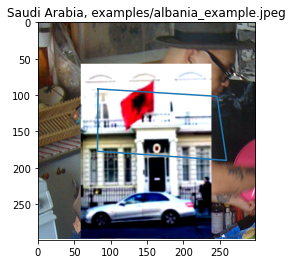

name
Slovenia        0.809349
Armenia         0.056496
Sierra Leone    0.030692
Lithuania       0.029183
Oman            0.027801
dtype: float32 [0.25493705 0.11872727 0.6698029  0.21214631 0.61685216 0.95344394
 0.27942586 0.9494183 ]
       prob      pred
0  0.809349  Slovenia


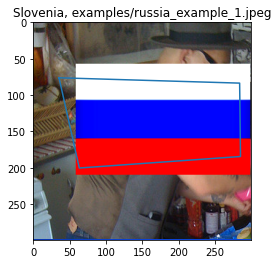

name
Saudi Arabia    0.200075
Nepal           0.140878
Antarctica      0.072969
Switzerland     0.048605
Micronesia      0.037559
dtype: float32 [0.38455123 0.28474522 0.6197283  0.27780598 0.64853185 0.76655567
 0.38341632 0.74715394]
       prob          pred
0  0.200075  Saudi Arabia


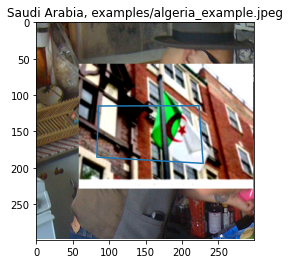

name
Curaçao    0.636838
Belarus    0.300065
Aruba      0.020006
Bahrain    0.015405
Oman       0.015354
dtype: float32 [0.22746153 0.19582587 0.6812801  0.19459432 0.6649414  1.0596693
 0.15990613 0.96124744]
       prob     pred
0  0.636838  Curaçao


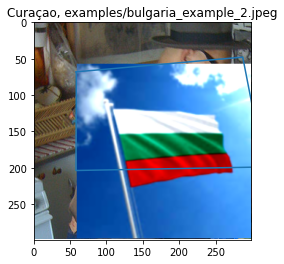

name
Micronesia      0.337193
Isle of Man     0.298884
Brunei          0.093908
Saudi Arabia    0.065486
Kiribati        0.046081
dtype: float32 [0.37887526 0.19062753 0.6861096  0.28993115 0.7157461  0.9514207
 0.37859672 0.9297693 ]
       prob        pred
0  0.337193  Micronesia


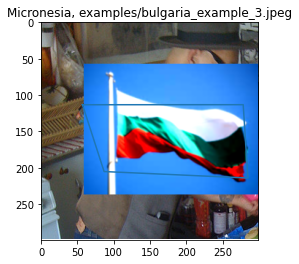

name
Zambia                                 0.230276
American Samoa                         0.201034
Pakistan                               0.102608
Bangladesh                             0.055065
French Southern and Antarctic Lands    0.036275
dtype: float32 [0.26263338 0.18017657 0.5558169  0.23466459 0.573598   0.8882757
 0.28528264 0.81079227]
       prob    pred
0  0.230276  Zambia


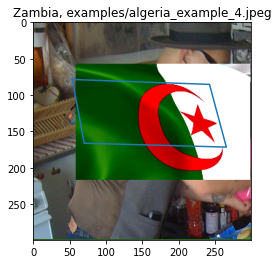

name
Zambia           0.499638
Nigeria          0.169597
Saint Lucia      0.074050
Barbados         0.026965
Côte d'Ivoire    0.023407
dtype: float32 [0.42274305 0.2916717  0.66571355 0.29999912 0.6900539  0.8793712
 0.42133573 0.8630022 ]
       prob    pred
0  0.499638  Zambia


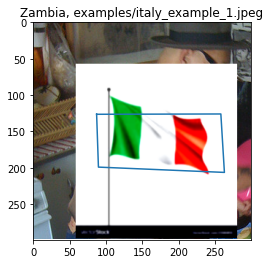

name
Algeria             0.692048
Mauritania          0.151271
Pakistan            0.131808
Christmas Island    0.004011
Maldives            0.003512
dtype: float32 [0.2706392  0.22933564 0.5960352  0.20077722 0.65690905 0.84268636
 0.2855587  0.8039229 ]
       prob     pred
0  0.692048  Algeria


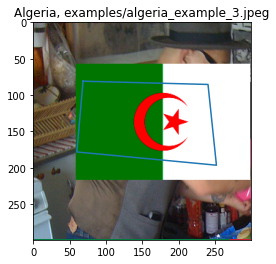

name
Zambia     0.255133
Congo      0.142138
Nigeria    0.091674
Ireland    0.036480
Tokelau    0.035757
dtype: float32 [0.37231898 0.28102595 0.6018845  0.2813832  0.5989345  0.7407279
 0.37573177 0.7736283 ]
       prob    pred
0  0.255133  Zambia


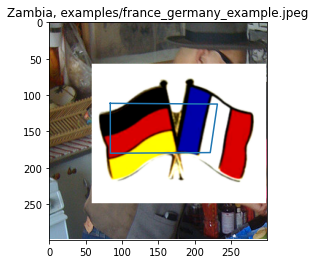

name
British Indian Ocean Territory                  0.187028
Saint Helena, Ascension and Tristan da Cunha    0.180071
United States Virgin Islands                    0.178490
New Zealand                                     0.066538
South Georgia and the South Sandwich Islands    0.059346
dtype: float32 [0.3625701  0.24472289 0.57972527 0.25589365 0.64841354 0.8097367
 0.35233495 0.79965013]
       prob                            pred
0  0.187028  British Indian Ocean Territory


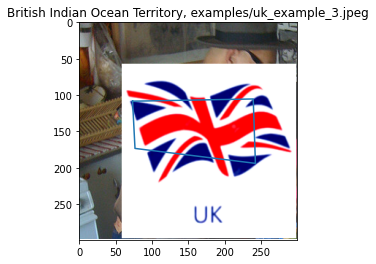

name
Gibraltar       0.164843
Burkina Faso    0.132194
Haiti           0.112765
Brunei          0.083198
Tajikistan      0.037532
dtype: float32 [0.43577337 0.3342787  0.7394752  0.34024101 0.7562396  0.88571364
 0.46925452 0.8446254 ]
       prob       pred
0  0.164843  Gibraltar


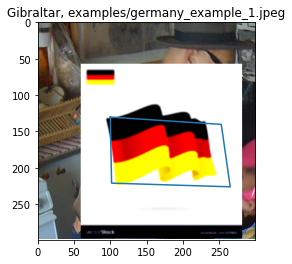

name
Antarctica    0.262711
Canada        0.238804
Bahrain       0.130569
Georgia       0.068670
Japan         0.039544
dtype: float32 [0.25425968 0.27713668 0.5676134  0.13574004 0.5844575  0.6568882
 0.2281149  0.7322279 ]
       prob        pred
0  0.262711  Antarctica


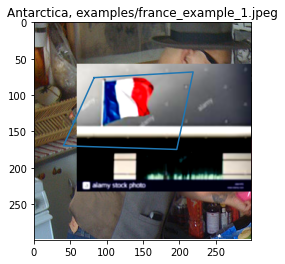

name
United Kingdom    0.962062
Macedonia         0.030064
Niue              0.002413
Israel            0.001225
Puerto Rico       0.000595
dtype: float32 [0.47017786 0.24246284 0.77385694 0.2570042  0.79295486 0.8543551
 0.47105598 0.81942904]
       prob            pred
0  0.962062  United Kingdom


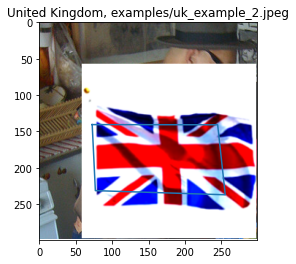

name
Canada            0.545695
Norfolk Island    0.163461
Cyprus            0.047550
Bangladesh        0.032021
Albania           0.029520
dtype: float32 [0.23523647 0.21947746 0.51715803 0.20299019 0.56869227 0.84481245
 0.25161862 0.8283965 ]
       prob    pred
0  0.545695  Canada


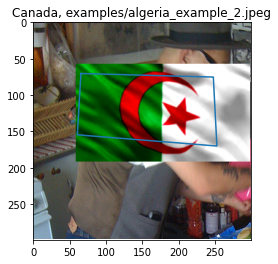

name
Montenegro     0.783222
Bermuda        0.153201
Timor-Leste    0.013783
Isle of Man    0.012636
Guam           0.011406
dtype: float32 [0.2939993  0.22739422 0.6435375  0.24627988 0.7246755  0.9810061
 0.28431624 1.066669  ]
       prob        pred
0  0.783222  Montenegro


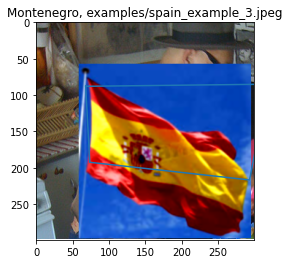

name
Antarctica      0.654320
Macao           0.194096
Cook Islands    0.021378
Cyprus          0.020749
Australia       0.017059
dtype: float32 [0.250727   0.21200195 0.50605667 0.22761208 0.54648167 0.83949184
 0.21420205 0.8115901 ]
      prob        pred
0  0.65432  Antarctica


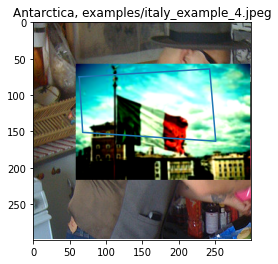

name
Bosnia and Herzegovina    0.583314
Nigeria                   0.158752
United Arab Emirates      0.076001
Tokelau                   0.068724
Ireland                   0.056184
dtype: float32 [0.33715725 0.22083142 0.6471026  0.22886354 0.6659535  0.90764195
 0.3409682  0.83845294]
       prob                    pred
0  0.583314  Bosnia and Herzegovina


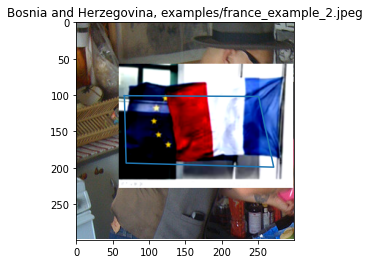

name
South Sudan    0.547004
Oman           0.259088
Jordan         0.047785
Costa Rica     0.026888
Bulgaria       0.014140
dtype: float32 [0.33768946 0.23385327 0.57772416 0.2081688  0.56531215 0.7111672
 0.30011803 0.8057449 ]
       prob         pred
0  0.547004  South Sudan


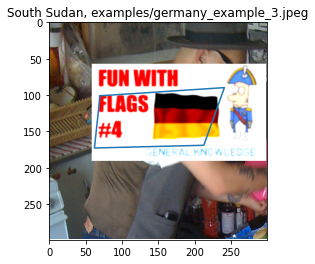

name
Kenya         0.118988
Ecuador       0.058295
Ethiopia      0.052997
Bahamas       0.044541
Azerbaijan    0.043525
dtype: float32 [0.42358083 0.26554513 0.68360835 0.2615449  0.7129895  0.77595496
 0.4681229  0.8089685 ]
       prob   pred
0  0.118988  Kenya


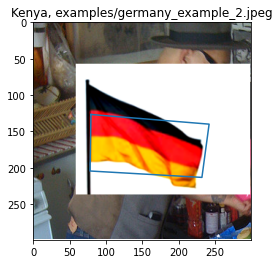

name
Qatar           0.302322
Micronesia      0.251198
Saudi Arabia    0.106764
Palau           0.054241
Isle of Man     0.051748
dtype: float32 [0.28343812 0.20053338 0.537744   0.23350067 0.55646896 0.9071223
 0.22693759 0.8822937 ]
       prob   pred
0  0.302322  Qatar


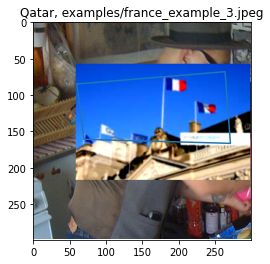

name
Australia                                       0.816659
New Zealand                                     0.181568
Tuvalu                                          0.000494
South Georgia and the South Sandwich Islands    0.000462
Anguilla                                        0.000301
dtype: float32 [0.24728261 0.24331442 0.6167822  0.18457866 0.608913   0.90509915
 0.1764424  0.8538027 ]
       prob       pred
0  0.816659  Australia


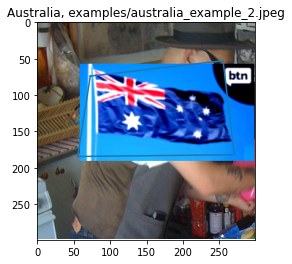

name
Lebanon             0.499608
French Polynesia    0.335655
Bermuda             0.094580
San Marino          0.045316
Spain               0.015967
dtype: float32 [0.16123821 0.35321128 0.65289295 0.16461068 0.656886   1.028226
 0.13824362 1.0136458 ]
       prob     pred
0  0.499608  Lebanon


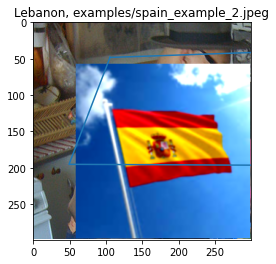

name
Brunei            0.782395
Guam              0.119585
Libya             0.024692
Gibraltar         0.012483
Western Sahara    0.011116
dtype: float32 [0.3513532  0.23699334 0.65232474 0.25402617 0.7007989  0.88875
 0.35470983 0.93717134]
       prob    pred
0  0.782395  Brunei


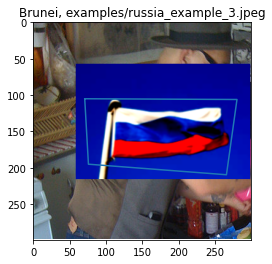

name
Isle of Man    0.353597
Gibraltar      0.112037
Tonga          0.099332
Qatar          0.082740
Guam           0.063299
dtype: float32 [0.38684946 0.26618057 0.6918323  0.32290843 0.7196728  0.94058084
 0.39517432 0.931534  ]
       prob         pred
0  0.353597  Isle of Man


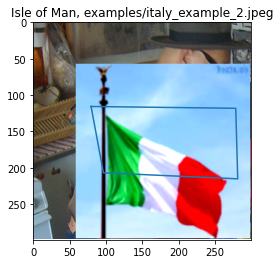

name
Palau         0.833599
Guam          0.070388
Albania       0.031779
Kazakhstan    0.010106
Cyprus        0.009804
dtype: float32 [0.3167273  0.16378993 0.62762034 0.2348268  0.6382882  0.95339483
 0.29325113 0.9483497 ]
       prob   pred
0  0.833599  Palau


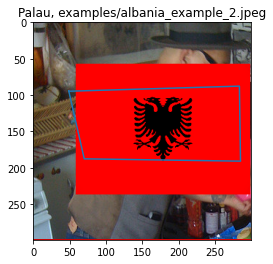

name
Latvia                  0.220316
Kuwait                  0.210100
Gibraltar               0.125058
Slovenia                0.080474
United Arab Emirates    0.079480
dtype: float32 [0.3964447  0.29033232 0.70049834 0.28934407 0.712515   0.87978595
 0.38904464 0.9724103 ]
       prob    pred
0  0.220316  Latvia


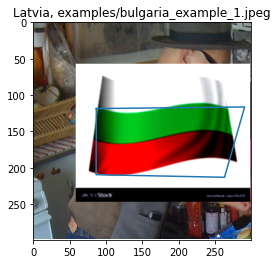

name
Germany     0.658159
Ukraine     0.163354
Bulgaria    0.047519
Gabon       0.024070
Russia      0.015690
dtype: float32 [0.27713144 0.17146726 0.6119849  0.18077523 0.6383257  0.73434156
 0.31662348 0.6563283 ]
       prob     pred
0  0.658159  Germany


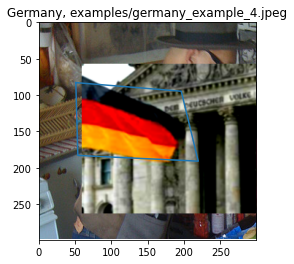

name
Antarctica      0.790201
Cook Islands    0.126273
Macao           0.050084
Albania         0.026011
Australia       0.004919
dtype: float32 [0.22211958 0.22819044 0.5621669  0.22005259 0.6153851  1.0231086
 0.13647543 0.9528611 ]
       prob        pred
0  0.790201  Antarctica


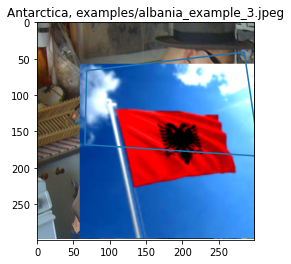

name
Gibraltar    0.796741
Qatar        0.049559
Palau        0.042646
Tonga        0.022874
Honduras     0.017890
dtype: float32 [0.33163816 0.12064896 0.6569862  0.20366798 0.6519018  0.91628414
 0.30489093 0.85031396]
       prob       pred
0  0.796741  Gibraltar


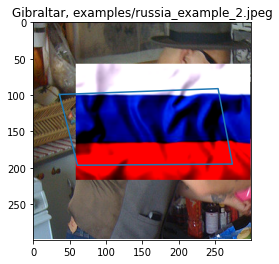

name
Nigeria                   0.607537
Ireland                   0.364432
United Arab Emirates      0.008755
Bosnia and Herzegovina    0.008624
Western Sahara            0.001967
dtype: float32 [0.2344281  0.19913816 0.5092901  0.21626002 0.5546306  0.91781455
 0.22068979 0.9723199 ]
       prob     pred
0  0.607537  Nigeria


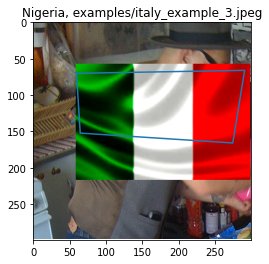

In [131]:
examples = glob.glob("examples/*.jpeg")
for example_fname in examples:
    example_raw = mpimage.imread(example_fname)
    
    d_contr = 2
    d_light = 0
    plt.imshow(example_raw)
    final_preds = []
    for scale in [0.8]:
        for shift in [0.2]:
            for n_clusters in [20]:
                example = module.preprocess_input(example_raw)
                #example = cluster_spatial(example, n_clusters=20)
                example = cv2.GaussianBlur(example, ksize=(11, 11), sigmaX=1)
                example_tuned = tune_contrast_light(example, d_contr=d_contr, d_light=d_light)
                
                preds, coords, blank = pred_resize_one_image(example_tuned, scale=scale, shift=shift)
                coords = coords.numpy()[0] 
                h, w = height, width
                plt.plot(np.concatenate([coords[1::2], [coords[1]]]) * w,
                         np.concatenate([coords[::2], [coords[0]]]) * h)
                plt.xlim(0, w)
                plt.ylim(h, 0)
                plt.imshow((blank + 1) * 0.5)
                #plt.imshow((example_tuned + 1) * 0.5)
                print(preds[:5], coords)
                final_preds.append({"prob": preds.values[0], "pred": preds.index[0]})
    final_preds = pd.DataFrame(final_preds).sort_values("prob", ascending=False)
    print(final_preds)
    plt.title(final_preds["pred"].iloc[0] + ", " + example_fname)
    plt.show()

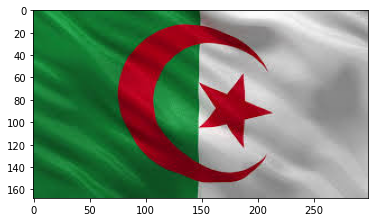

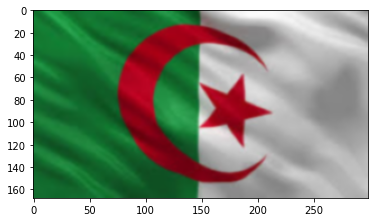

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


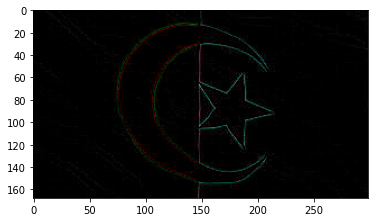

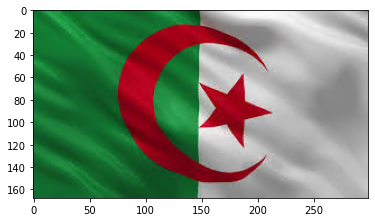

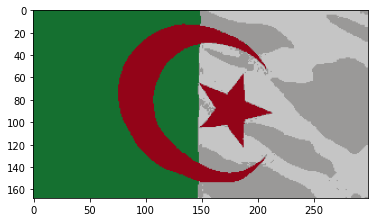

In [405]:

show(example)
plt.show()
amount = 1
blurred = cv2.GaussianBlur(example, ksize=(11, 11), sigmaX=1)
show(blurred)
plt.show()
diff = example - blurred
plt.imshow(diff)
plt.show()
threshold = np.quantile(np.abs(diff), 0.95)
borders = (np.abs(diff).sum(axis=2) > threshold)
borders = np.stack([borders] * 3, axis=2)
sharpend = borders * diff * amount + blurred
show(sharpend)
plt.show()
clustered = cluster(sharpend, n_clusters=4)
show(clustered)

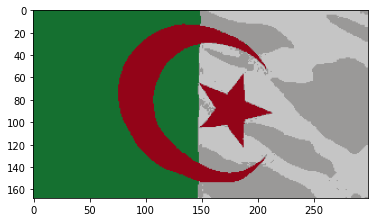

name
Switzerland    0.040142
Bahrain        0.039044
Cuba           0.038377
Pakistan       0.037112
Nepal          0.034657
dtype: float32
       prob         pred
0  0.040142  Switzerland


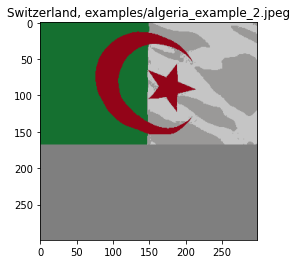

In [406]:
examples = glob.glob("examples/*.jpeg")
for example_fname in ['examples/algeria_example_2.jpeg']:
    
    example_raw = mpimage.imread(example_fname)
    example = module.preprocess_input(example_raw)
    example = clustered
    #example = cluster(example, n_clusters=3)
    plt.imshow((example + 1) * 0.5)
    plt.show()
    final_preds = []
    for d_contr in [1]:
        for d_light in [0]:
            example_tuned = tune_contrast_light(example, d_contr=d_contr, d_light=d_light, rgb=[1, 1, 1])
            ex_w, ex_h = example.shape[:2]
            min_factor = min(width / ex_w , height / ex_h)
            resized_example1 = cv2.resize(example_tuned, (int(ex_h * min_factor), int(ex_w * min_factor)))
            blank = np.zeros((width, height, 3))
            blank[:resized_example1.shape[0], :resized_example1.shape[1], :] = resized_example1
            #plt.imshow((blank + 1) * 0.5)
            preds = pred_one_image(blank)
            print(preds[:5])
            final_preds.append({"prob": preds.values[0], "pred": preds.index[0]})
            show(blank)
    final_preds = pd.DataFrame(final_preds).sort_values("prob", ascending=False)
    print(final_preds)
    plt.title(final_preds["pred"].iloc[0] + ", " + example_fname)
    plt.show()

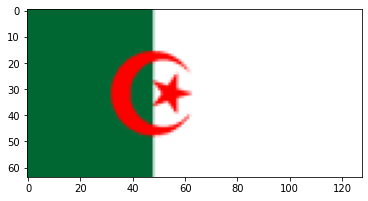

In [214]:
show(images[2])

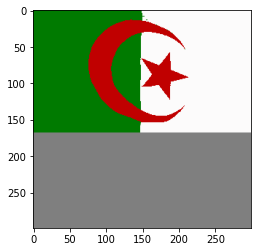

In [258]:
show(blank)

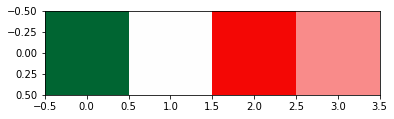

In [216]:
colors_im = get_colors(images[2])
show(colors_im)

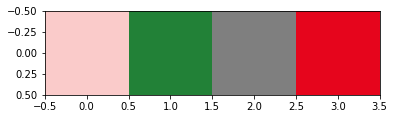

In [217]:
colors_ex = get_colors(blank)
show(colors_ex)

In [220]:
pd.DataFrame((colors_im[0] + 1) * 0.5, columns=["r", "g", "b"])

r         g         b
0  0.003063  0.399272  0.199640
1  0.997680  0.997857  0.997384
2  0.956938  0.030215  0.022640
3  0.979248  0.546569  0.543355

In [221]:
pd.DataFrame((colors_ex[0] + 1) * 0.5, columns=["r", "g", "b"])

r         g         b
0  0.982231  0.798822  0.794474
1  0.135502  0.507935  0.218401
2  0.501061  0.500837  0.499158
3  0.904345  0.021326  0.110114

In [211]:
0.440755/ 0.383785

1.1484424873301458

In [212]:
ex1 = tune_contrast_light(colors_ex[0], d_light=0, d_contr=1, rgb=[1.655, 1.155, 1.15])
pd.DataFrame((ex1 + 1) * 0.5, columns=["r", "g", "b"]).mean()

r    0.733887
g    0.493431
b    0.441353
dtype: float64

In [139]:
preds.index

Index(['Afghanistan', 'Saudi Arabia', 'Sri Lanka', 'Mongolia', 'North Korea',
       'Serbia', 'Cambodia', 'Virgin Islands', 'Slovakia', 'Turkmenistan',
       ...
       'Tokelau', 'Dominica', 'Greece', 'United Kingdom', 'Marshall Islands',
       'Czechia', 'Botswana', 'Jamaica', 'United States', 'Tanzania'],
      dtype='object', name='name', length=234)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


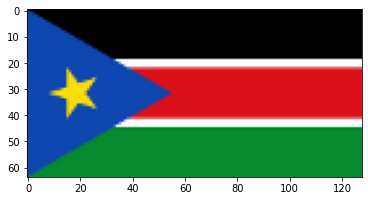

In [142]:
rows = []
for i in range(images.shape[0]):
    print(i)
    show(images[i])
    preds = pred_resize_one_image(images[i]).sort_values(ascending=False)
    row = {"pred":preds.index[0], "y": df["name"].iloc[i]}
    rows.append(row)

In [144]:
res = pd.DataFrame(rows)

In [146]:
(res["pred"] == res["y"]).mean()

0.5299145299145299

In [147]:
res

pred                             y
0       Afghanistan                   Afghanistan
1           Albania                       Albania
2           Algeria                       Algeria
3             Tonga                       Andorra
4            Angola                        Angola
..              ...                           ...
229   United States                 United States
230           Chile            Vatican City State
231  Virgin Islands                Virgin Islands
232     South Korea  United States Virgin Islands
233     South Sudan                   South Sudan

[234 rows x 2 columns]

In [235]:
def pred_resize_one_image(example, scale=1, x=0, y=0, mask=None):
    ex_w, ex_h = example.shape[:2]
    min_factor = min(width / ex_w , height / ex_h) * scale
    resized_example1 = cv2.resize(example, (int(ex_h * min_factor), int(ex_w * min_factor)))
    blank = np.zeros((width, height, 3))
    if mask is not None:
        resized_mask = cv2.resize(mask, (int(ex_h * min_factor), int(ex_w * min_factor)))
        resized_example1 *= resized_mask
    blank[x: x + resized_example1.shape[0], y: y + resized_example1.shape[1], :] = resized_example1
    show(blank)
    preds = pred_one_image(blank)
    return preds

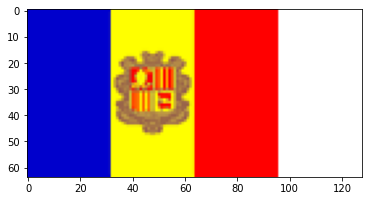

In [236]:
show(images[3])

name
Andorra             0.55
Mongolia            0.36
Turkmenistan        0.07
Portugal            0.01
Serbia              0.00
                    ... 
Botswana            0.00
Marshall Islands    0.00
United Kingdom      0.00
Jamaica             0.00
United States       0.00
Length: 234, dtype: float32

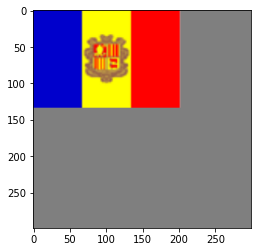

In [237]:
pred_resize_one_image(images[3], scale=0.9,  mask=masks[3]).round(2)

## SHAPLY

In [74]:
import shap

In [367]:
explainer = shap.DeepExplainer(seq2, batch[:10])

In [368]:
shap_vals = explainer.shap_values(batch[:1])

KeyboardInterrupt: 